<a href="https://colab.research.google.com/github/Goshective/Project_ML/blob/f1-score/Project_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Загрузка данных

In [ ]:
!pip install kaggle
!pip install torch torchvision

In [ ]:
from google.colab import files

# Upload the Kaggle API key file
uploaded = files.upload()

# Move the uploaded file to the appropriate directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# Download the dataset
!kaggle competitions download -c ml-intensive-yandex-autumn-2023

 99% 977M/988M [00:09<00:00, 104MB/s] 
100% 988M/988M [00:09<00:00, 113MB/s]


Перевод в zip

In [ ]:
import zipfile

zip_file_path = "ml-intensive-yandex-autumn-2023.zip"
extracted_folder = "dataset"

with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extractall(extracted_folder)

In [ ]:
!ls -l dataset/data/

total 2268
drwxr-xr-x 2 root root 217088 Dec  3 14:58 test_images
-rw-r--r-- 1 root root 204908 Dec  3 14:58 train_answers.csv
drwxr-xr-x 2 root root 946176 Dec  3 14:58 train_images
drwxr-xr-x 2 root root 946176 Dec  3 14:58 train_lung_masks


## Перевод в датасеты

Находим пути

In [ ]:
import os
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.v2 import Compose, PILToTensor, ToDtype, Normalize

TEST_RANGE = 6920
TEST_MODE = 105106

# Define paths
data_folder = "dataset/data"
train_images_folder = os.path.join(data_folder, "train_images")
train_masks_folder = os.path.join(data_folder, "train_lung_masks")
test_images_folder = os.path.join(data_folder, "test_images")
train_ans_path = os.path.join(data_folder, "train_answers.csv")

In [ ]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, images_folder, transform=None, mode=None):
        self.dataframe = dataframe
        self.images_folder = images_folder
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # load image from folder
        img_name = os.path.join(self.images_folder, f'img_{self.dataframe.iloc[idx, 0]}.png')
        image = Image.open(img_name).convert("L")

        if self.transform:
            image = transforms.ToTensor()(image)

        if self.mode == TEST_MODE:
            return image

        return image, self.dataframe["target_feature"][idx]

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))
])

# Create datasets
train_ans_pd = pd.read_csv(train_ans_path)
train_ans_tensor = torch.tensor(train_ans_pd["target_feature"].values)

train_mask_dataset = CustomDataset(dataframe=train_ans_pd, images_folder=train_masks_folder, transform=transform)
train_image_dataset = CustomDataset(dataframe=train_ans_pd, images_folder=train_images_folder, transform=transform)

test_dataset = CustomDataset(dataframe=train_ans_pd, images_folder=test_images_folder, transform=transform, mode=TEST_MODE)

print(train_image_dataset[0][0].shape,
      train_image_dataset[0][1])

torch.Size([1, 256, 256]) 0


In [ ]:
# for img in train_image_dataset:
#   print(type(img))
#   break
# train_image_tensor = torch.stack([item for item in train_image_dataset])
# train_image_tensor.shape

# train_set = torch.cat((train_image_tensor, train_ans_tensor), dim=1)

# train_set[0][1]

## Проверка данных

In [ ]:
train_image_loader = DataLoader(train_image_dataset, batch_size=32, shuffle=True) # not using later
train_mask_loader = DataLoader(train_mask_dataset, batch_size=32, shuffle=False)

for img, ans in train_image_loader:
  print(img.shape)
  print(img[0], ans[31]) # because of batch
  break

for mask, ans in train_mask_loader:
  print(mask.shape)
  break

print(train_ans_tensor[0])

torch.Size([32, 1, 256, 256])
tensor([[[0.4039, 0.4039, 0.4039,  ..., 0.1922, 0.1922, 0.1961],
         [0.4039, 0.4039, 0.4039,  ..., 0.0980, 0.0980, 0.0980],
         [0.4039, 0.4039, 0.4039,  ..., 0.0353, 0.0353, 0.0353],
         ...,
         [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0431],
         [0.1098, 0.1020, 0.1020,  ..., 0.0000, 0.0000, 0.0431],
         [0.5216, 0.5020, 0.5020,  ..., 0.0000, 0.0000, 0.0510]]]) tensor(0)
torch.Size([32, 1, 256, 256])
tensor(0)


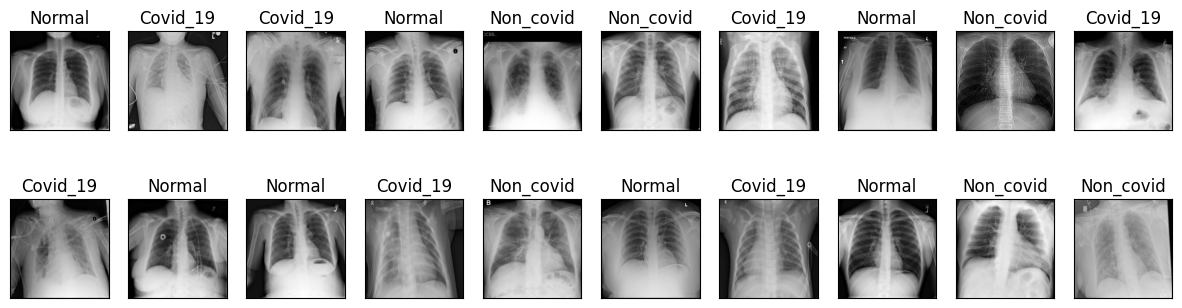

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))
names = ["Normal", "Non_covid", "Covid_19"]

for i, (img, ans) in enumerate(train_image_dataset):
    if i == 20:
      break
    plt.subplot(2, 10, i + 1)
    plt.imshow(img.permute(1, 2, 0)  * 0.25 + 0.5, cmap=plt.get_cmap('gray'))
    plt.xticks([])
    plt.yticks([])
    plt.title(names[ans])

plt.show()

# Baseline решение

## Модель

In [ ]:
from torch import nn
from torchsummary import summary

model_0 = nn.Sequential(
    # nn.Conv2d(1, 16, 3, padding=1),
    # nn.ReLU(),
    # nn.BatchNorm2d(16),
    # nn.MaxPool2d(4, 4), # -> (16, 256, 256) -> (16, 64, 64)

    # nn.Conv2d(16, 32, 3, padding=1),
    # nn.ReLU(),
    # nn.BatchNorm2d(32),
    # nn.MaxPool2d(4, 4), # -> (32, 64, 64) -> (32, 16, 16)
    # nn.Dropout2d(p=0.2),

    # nn.Conv2d(32, 64, 3, padding=1),
    # nn.ReLU(),
    # nn.BatchNorm2d(64),
    # nn.MaxPool2d(4, 4), # -> (64, 16, 16) -> (64, 4, 4)
    # nn.Dropout2d(p=0.2),

    # nn.Conv2d(64, 128, 3, padding=1),
    # nn.ReLU(),
    # nn.BatchNorm2d(128),
    # nn.MaxPool2d(4, 4), # -> (128, 4, 4) -> (128, 1, 1)

    nn.Flatten(start_dim=-3),
    # nn.Linear(in_features=128, out_features=16),
    # nn.ReLU(),
    nn.Linear(in_features=256**2, out_features=3),
    nn.Softmax(dim=1),
).to(device)

print(summary(model_0, (1, 256, 256)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 65536]               0
            Linear-2                    [-1, 3]         196,611
           Softmax-3                    [-1, 3]               0
Total params: 196,611
Trainable params: 196,611
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 0.50
Params size (MB): 0.75
Estimated Total Size (MB): 1.50
----------------------------------------------------------------
None


In [ ]:
# m = nn.Softmax(dim=1)
# input = torch.randn(2, 3)
# output = m(input)
# print(input, output)

In [ ]:
rand_tensor = torch.rand((32, 1, 256, 256)).to(device)
pred = model_0(rand_tensor)
pred.shape

torch.Size([32, 3])

## Настройка цикла обучения

### Разделение выборки

In [ ]:
from torch.utils.data import random_split

train_set, valid_set = random_split(train_image_dataset, (0.95, 0.05))

train_set[0]

(tensor([[[0.1490, 0.0588, 0.0118,  ..., 0.4627, 0.4863, 0.5451],
          [0.1412, 0.0549, 0.0078,  ..., 0.2157, 0.2275, 0.2667],
          [0.1412, 0.0510, 0.0078,  ..., 0.1020, 0.1098, 0.1451],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0157, 0.0667, 0.1647],
          [0.0000, 0.0000, 0.0000,  ..., 0.0118, 0.0667, 0.1647],
          [0.0039, 0.0039, 0.0000,  ..., 0.0157, 0.0667, 0.1647]]]),
 0)

### Константы для обучения

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_EPOCHS = 30
NUM_LOG_ITERS = 200

metrics_hist = {"train":
                          {"accuracy": [], "loss": [], "f1": []},
                "valid":
                          {"accuracy": [], "loss": [], "f1": []}
                }


optimizer = torch.optim.SGD(model_0.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE)

for X,y in train_loader:
  print(X.shape, y.shape)
  print(X[0].shape)
  break

torch.Size([32, 1, 256, 256]) torch.Size([32])
torch.Size([1, 256, 256])


In [ ]:
!pip install pytorch-ignite

In [ ]:
from ignite.engine import create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, Precision, Recall, Fbeta
from sklearn.metrics import f1_score

for a,b in train_loader:
  a = a.to(device)
  b = b.to(device)
  print(a.shape)
  ppp = model_0(a)
  ppp2 = ppp.squeeze()
  print(b.shape)
  print("result of model:", ppp.shape, "->", ppp2.shape)
  criterion(ppp2, b)
  break

trainer = create_supervised_trainer(model_0, optimizer, criterion, device)

precision = Precision(average=False)
recall = Recall(average=False)
F1 = Fbeta(beta=1.0, precision=precision, recall=recall, average=True) # artificial f1

metrics = {
    "accuracy": Accuracy(),
    "loss": Loss(criterion),
    "f1": F1
}

train_evaluator = create_supervised_evaluator(model_0, metrics=metrics, device=device)
valid_evaluator = create_supervised_evaluator(model_0, metrics=metrics, device=device)

torch.Size([32, 1, 256, 256])
torch.Size([32])
result of model: torch.Size([32, 3]) -> torch.Size([32, 3])


In [ ]:
# print(F1(np.array([0.001, 0.9, 0.099])))

### Лог-функции и вывод графиков

In [ ]:
from IPython.display import clear_output
import numpy as np

def show_metrics(hist: dict):  #, test_f):
    clear_output()

    train_acc = hist['train']['accuracy']
    train_loss = hist['train']['loss']
    # train_f1 = hist['valid']['f1']

    test_acc = hist['valid']['accuracy']
    test_loss = hist['valid']['loss']
    test_f1 = hist['valid']['f1']

    range_loss = np.arange(len(train_loss))
    range_acc = np.arange(len(train_acc))
    range_f1 = np.arange(len(test_f1))


    plt.figure(figsize=(24,12))

    plt.subplot(1, 3, 1)
    plt.title('Loss')

    plt.plot(range_loss, train_loss, label=f"train loss = {train_loss[-1]:.5f}")
    plt.plot(range_loss, test_loss, label=f"test loss = {test_loss[-1]:.5f}")

    plt.legend()

    plt.yscale('log')
    plt.grid()


    plt.subplot(1, 3, 2)
    plt.title('Accuracy')

    plt.plot(range_acc, train_acc, label=f"train acc = {train_acc[-1]:.5f}")
    plt.plot(range_acc, test_acc, label=f"test acc = = {test_acc[-1]:.5f}")

    plt.legend()

    plt.yscale('log')
    plt.grid()


    plt.subplot(1, 3, 3)
    plt.title('F1-score')

    plt.plot(range_f1, test_f1, label="test_f")


    plt.yscale('log')
    plt.grid()

    plt.show()

In [ ]:
from ignite.engine import Events


def log_iter_loss(engine):
    print(f"Epoch[{engine.state.epoch}] - Iter[{engine.state.iteration}]: loss = {engine.state.output}")

trainer.add_event_handler(Events.ITERATION_COMPLETED(every=NUM_LOG_ITERS), log_iter_loss)


def compute_epoch_results(engine):
    train_evaluator.run(train_loader)
    valid_evaluator.run(valid_loader)

trainer.add_event_handler(Events.EPOCH_COMPLETED, compute_epoch_results)


def log_epoch_results(engine, label=""):
    result = ', '.join([f"{m} = {v}" for m, v in engine.state.metrics.items()])

    for m, v in engine.state.metrics.items():
        metrics_hist[label.lower()][m].append(v)


    # func is calling 2 times for train and valid
    if len(metrics_hist['valid']['loss']) == 1:
        print(f"{temp_results[0][0]} Res:", temp_results[0][1])
        print(f"{label} Res:", result)
        temp_resulst = []

    if len(metrics_hist['valid']['loss']) == len(metrics_hist['train']['loss']):

        # no graphics with only 1 point
        if len(metrics_hist['valid']['loss']) > 1:

            show_metrics(metrics_hist)

            print(f"{temp_results[0][0]} Res:", temp_results[0][1])
            print(f"{label} Res:", result)
            temp_resulst = []

    else:
        temp_results.append((label, result))

train_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_results, label="Train")
valid_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_results, label="Valid")
temp_results = []

LR Scheduler

In [ ]:
from ignite.handlers.param_scheduler import ReduceLROnPlateauScheduler

scheduler = ReduceLROnPlateauScheduler(
    optimizer,
    metric_name="loss",
    factor=0.5,
    patience=1,
    threshold=0.05
)

def print_lr():
    for param_group in optimizer.param_groups:
        print(f"Optimizer learning rate = {param_group['lr']}")

valid_evaluator.add_event_handler(Events.COMPLETED, scheduler)
valid_evaluator.add_event_handler(Events.COMPLETED, print_lr)

## Подсчет F1

## Обучение

Обновите все предыдущие ячейки перед запуском (начиная с "Baseline решения")

In [ ]:
trainer.run(train_loader, NUM_EPOCHS)

Epoch[1] - Iter[200]: loss = 0.9542477130889893
Epoch[1] - Iter[400]: loss = 0.7707394957542419
Epoch[1] - Iter[600]: loss = 0.937144935131073
Epoch[1] - Iter[800]: loss = 0.9372259378433228


ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: 
ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: 


KeyboardInterrupt: ignored

## Предсказания для теста

In [ ]:
print(test_dataset[0].shape)

model_0.eval()
y_test = []
for i in range(TEST_RANGE):
    x = torch.stack([test_dataset[i],])
    y_pred = torch.argmax(model_0(x))
    y_test.append(y_pred.item())

print(len(y_test), y_test[:2])

In [ ]:
y_dataset = pd.DataFrame({'target_feature': y_test})
y_dataset

In [ ]:
# from google.colab import files

y_dataset.to_csv('df.csv', index_label='id')
files.download('df.csv')